In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import glob
import cv2
import numpy as np
import PIL


/Users/leannwoo/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=100))
model.add(Dense(units=10, activation='softmax'))

In [3]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [4]:
images = glob.glob('*.jpg')
images.sort()
images

['eyespot_Abudefduf_Abudefduf sparoides_929157376.jpg',
 'eyespot_Acanthurus_Acanthurus tennentii_-1986886053.jpg',
 'eyespot_Acanthurus_Acanthurus thompsoni_-1325670399.jpg',
 'eyespot_Amblycirrhitus_Amblycirrhitus bimacula_-2115602772.jpg',
 'eyespot_Amblycirrhitus_Amblycirrhitus bimacula_1677061943.jpg',
 'eyespot_Apogon_Apogon cavitiensis_-1692469642.jpg',
 'eyespot_Apogon_Apogon endekataenia_725932159.jpg',
 'eyespot_Apogon_Apogon melas_1761120890.jpg',
 'eyespot_Apogon_Apogon nigrofasciatus_-2146149423.jpg',
 'eyespot_Bodianus_Bodianus diana_1512476701.jpg',
 'eyespot_Centropyge_Centropyge multispinis_-1761499235.jpg',
 'eyespot_Centropyge_Centropyge narcosis_-1843367047.jpg',
 'eyespot_Centropyge_Centropyge nigriocellus_414384710.jpg',
 'eyespot_Chaetodon_Chaetodon excelsa_853070272.jpg',
 'eyespot_Chaetodon_Chaetodon ulietensis_-1430510223.jpg',
 'eyespot_Chaetodon_Chaetodon zanzibariensis_-1292827274.jpg',
 'eyespot_Chrysiptera_Chrysiptera biocellata_-1668359301.jpg',
 'eyespo

In [5]:
labels_x = np.repeat([[1,0]], 40, axis = 0)
labels_y = np.repeat([[0,1]], 40, axis = 0)

labels = np.concatenate([labels_x, labels_y])
labels

array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0, 1],
       [0,

In [6]:
datagen = ImageDataGenerator(rotation_range=40,
                            width_shift_range=0.2,
                            height_shift_range=0.2,
                            rescale=1./255,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

In [9]:
img = load_img('/Users/leannwoo/Dropbox/machine_learning_fishes/image_classifiers/Eyespots_all_species/eyespot/Apogon_Apogon cavitiensis_-1692469642.jpg')

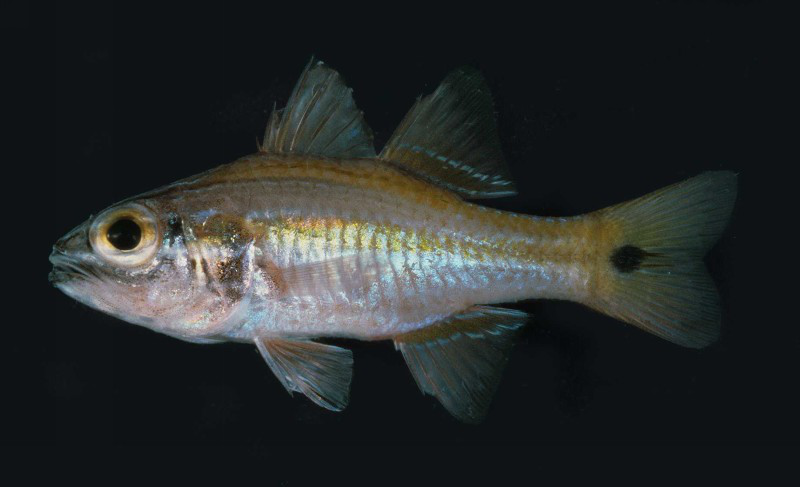

In [10]:
img

In [11]:
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
x

array([[[[14., 18., 21.],
         [15., 19., 22.],
         [15., 19., 22.],
         ...,
         [14., 18., 21.],
         [14., 18., 21.],
         [14., 18., 21.]],

        [[14., 18., 21.],
         [15., 19., 22.],
         [15., 19., 22.],
         ...,
         [14., 18., 21.],
         [14., 18., 21.],
         [14., 18., 21.]],

        [[14., 18., 21.],
         [15., 19., 22.],
         [15., 19., 22.],
         ...,
         [14., 18., 21.],
         [14., 18., 21.],
         [14., 18., 21.]],

        ...,

        [[15., 19., 22.],
         [15., 19., 22.],
         [15., 19., 22.],
         ...,
         [15., 19., 22.],
         [15., 19., 22.],
         [15., 19., 22.]],

        [[15., 19., 22.],
         [15., 19., 22.],
         [15., 19., 22.],
         ...,
         [15., 19., 22.],
         [15., 19., 22.],
         [15., 19., 22.]],

        [[15., 19., 22.],
         [15., 19., 22.],
         [15., 19., 22.],
         ...,
         [15., 19., 22.],
        

In [12]:
i = 0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='preview', save_prefix='eyespot', save_format='jpeg'):
    i += 1
    if i>20:
        break

In [13]:
import os
os.getcwd()

'/Users/leannwoo/machine_learning_fishes'

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = '/Users/leannwoo/Dropbox/machine_learning_fishes/image_classifiers/Eyespots_all_species/'
validation_data_dir = '/Users/leannwoo/Dropbox/machine_learning_fishes/image_classifiers/Eyespots_all_species_validation/'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 1
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [17]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

train_generator[1][0][0].shape

Found 70 images belonging to 2 classes.
Found 10 images belonging to 2 classes.


(150, 150, 3)

In [18]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')
model.save('second_try.h5')

Epoch 1/1
125/125 [==============================] - 124s 989ms/step - loss: 0.6874 - acc: 0.5980 - val_loss: 0.8491 - val_acc: 0.5000


## Reload model and use it to predict

In [19]:
from keras.models import load_model
import cv2

def resizeFish(img):
    # standardize size for prediction step
    img = cv2.resize(img, (150, 150))
    img = img/255.0
    img = img.reshape((1,) + img.shape)
    #res = model.predict(img)
    return(img)


model = load_model('second_try.h5')


# get a fish with an eye

eyepath = "/Users/leannwoo/Dropbox/machine_learning_fishes/image_classifiers/Eyespots_all_species/eyespot/Apogon_Apogon cavitiensis_-1692469642.jpg"
noeyepath = "/Users/leannwoo/Dropbox/machine_learning_fishes/image_classifiers/Eyespots_all_species/noeyespot/Amphichaetodon_Amphichaetodon howensis_-369771762.jpg"

eye = cv2.imread(eyepath)
noeye = cv2.imread(noeyepath)

eye2 = resizeFish(eye)
noeye2 = resizeFish(noeye)

In [20]:
eye2
eye2.shape

(1, 150, 150, 3)

In [22]:
#newimg = eye2.reshape((1,) + eye2.shape)
#newimg = np.squeeze(eye2)
model.predict(eye2, verbose=1)


1/1 [==============================] - 0s 22ms/step


array([[0.7199854 , 0.41282707]], dtype=float32)

In [23]:
model.predict(noeye2)

array([[0.21038269, 0.7787117 ]], dtype=float32)

In [82]:
model.predict(eye2)

array([[0.49574322]], dtype=float32)

In [83]:
model.predict(noeye2)

array([[0.49203187]], dtype=float32)